In [1]:
from utils.hparams import hparams,set_hparams
from preprocessing.data_gen_utils import get_pitch_parselmouth,get_pitch_crepe
from utils.pitch_utils import norm_interp_f0
from network.vocoders.base_vocoder import VOCODERS
from modules.fastspeech.pe import PitchExtractor
import numpy as np
from preprocessing.hubertinfer import Hubertencoder
from network.diff.diffusion import GaussianDiffusion
from utils.pitch_utils import denorm_f0
from network.diff.candidate_decoder import FFT
from network.diff.net import DiffNet
from network.vocoders.base_vocoder import get_vocoder_cls, BaseVocoder
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import utils
import librosa
import resampy
import torchcrepe
import soundfile as sf
from utils.pitch_utils import f0_to_coarse


DIFF_DECODERS = {
    'wavenet': lambda hp: DiffNet(hp['audio_num_mel_bins']),
    'fft': lambda hp: FFT(
        hp['hidden_size'], hp['dec_layers'], hp['dec_ffn_kernel_size'], hp['num_heads']),
}
#===========这里填写checkpoints对应的exp_name(项目名,ckpt所在文件夹的名字),ckpt和config路径==========
_=set_hparams(config='checkpoints/SVC/config.yaml', exp_name='SVC',infer=True,reset=True,hparams_str='', print_hparams=False)
modelpath='./checkpoints/SVC/model_ckpt_steps_240000.ckpt'
#=============================================================
mel_bins = hparams['audio_num_mel_bins']
model = GaussianDiffusion(
        phone_encoder=Hubertencoder(hparams['hubert_path']),
        out_dims=mel_bins, denoise_fn=DIFF_DECODERS[hparams['diff_decoder_type']](hparams),
        timesteps=hparams['timesteps'],
        K_step=hparams['K_step'],
        loss_type=hparams['diff_loss_type'],
        spec_min=hparams['spec_min'], spec_max=hparams['spec_max'],
    )
def load_ckpt(model,ckpt_base_dir, model_name='model', force=True, strict=True):
        utils.load_ckpt(model, ckpt_base_dir, model_name, force, strict)
load_ckpt(model,modelpath, strict=True)
model.cuda()
pe = PitchExtractor().cuda()
utils.load_ckpt(pe, hparams['pe_ckpt'], 'model', strict=True)
pe.eval()
print('model loaded')

e:\Codedata\anaconda\envs\diffsinger\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


| load 'model' from './checkpoints/SVC/model_ckpt_steps_240000.ckpt'.
| load 'model' from 'checkpoints/0102_xiaoma_pe/model_ckpt_steps_60000.ckpt'.
model loaded


In [2]:
def file2temporary_dict(wav_fn):
    '''
        read from file, store data in temporary dicts
    '''
    song_info = wav_fn.split('/')
    item_name = raw_item_name = song_info[-1].split('.')[-2]
    temp_dict = {}

    temp_dict['wav_fn'] = wav_fn
    temp_dict['spk_id'] = 'opencpop'

    return item_name,temp_dict
    
def temporary_dict2processed_input(item_name, temp_dict,use_crepe=True,thre=0.05):
    '''
        process data in temporary_dicts
    '''
    encoder=Hubertencoder(hparams['hubert_path'])
    binarization_args=hparams['binarization_args']
    def get_pitch(wav, mel):
        # get ground truth f0 by self.get_pitch_algorithm
        if use_crepe:
            gt_f0,coarse_f0 = get_pitch_crepe(wav, mel, hparams,thre)#
        else:
            gt_f0,coarse_f0 =get_pitch_parselmouth(wav, mel, hparams)
        processed_input['f0'] = gt_f0
        processed_input['pitch'] = coarse_f0

    def get_align(meta_data, mel, phone_encoded, hop_size=hparams['hop_size'], audio_sample_rate=hparams['audio_sample_rate']):
        mel2ph = np.zeros([mel.shape[0]], int)
        start_frame=1
        ph_durs = mel.shape[0]/phone_encoded.shape[0]
        if hparams['debug']:
            print(mel.shape,phone_encoded.shape,mel.shape[0]/phone_encoded.shape[0])
        for i_ph in range(phone_encoded.shape[0]):
            
            end_frame = int(i_ph*ph_durs +ph_durs+ 0.5)
            mel2ph[start_frame:end_frame+1] = i_ph + 1
            start_frame = end_frame+1

        processed_input['mel2ph'] = mel2ph

    if hparams['vocoder'] in VOCODERS:
        wav, mel = VOCODERS[hparams['vocoder']].wav2spec(temp_dict['wav_fn'])
    else:
        wav, mel = VOCODERS[hparams['vocoder'].split('.')[-1]].wav2spec(temp_dict['wav_fn'])
    processed_input = {
        'item_name': item_name, 'mel': mel,
        'sec': len(wav) / hparams['audio_sample_rate'], 'len': mel.shape[0]
    }
    processed_input = {**temp_dict, **processed_input} # merge two dicts

    if binarization_args['with_f0']:
        get_pitch(wav, mel)
    if binarization_args['with_hubert']:
        
        hubert_encoded = processed_input['hubert'] = encoder.encode(temp_dict['wav_fn'])
        if binarization_args['with_align']:
            get_align(temp_dict, mel, hubert_encoded)

    return processed_input
def getitem(item):
    max_frames = hparams['max_frames']
    spec = torch.Tensor(item['mel'])[:max_frames]
    energy = (spec.exp() ** 2).sum(-1).sqrt()
    mel2ph = torch.LongTensor(item['mel2ph'])[:max_frames] if 'mel2ph' in item else None
    f0, uv = norm_interp_f0(item["f0"][:max_frames], hparams)
    hubert=torch.Tensor(item['hubert'][:hparams['max_input_tokens']])
    pitch = torch.LongTensor(item.get("pitch"))[:max_frames]
    sample = {
        "item_name": item['item_name'],
        "hubert":hubert,
        "mel": spec,
        "pitch": pitch,
        "energy": energy,
        "f0": f0,
        "uv": uv,
        "mel2ph": mel2ph,
        "mel_nonpadding": spec.abs().sum(-1) > 0,
    }
    return sample
def processed_input2batch(samples):
    '''
        Args:
            samples: one batch of processed_input
        NOTE:
            the batch size is controlled by hparams['max_sentences']
    '''
    if len(samples) == 0:
        return {}
    item_names = [s['item_name'] for s in samples]
    hubert = utils.collate_2d([s['hubert'] for s in samples], 0.0)
    f0 = utils.collate_1d([s['f0'] for s in samples], 0.0)
    pitch = utils.collate_1d([s['pitch'] for s in samples])
    uv = utils.collate_1d([s['uv'] for s in samples])
    energy = utils.collate_1d([s['energy'] for s in samples], 0.0)
    mel2ph = utils.collate_1d([s['mel2ph'] for s in samples], 0.0) \
        if samples[0]['mel2ph'] is not None else None
    mels = utils.collate_2d([s['mel'] for s in samples], 0.0)
    mel_lengths = torch.LongTensor([s['mel'].shape[0] for s in samples])

    batch = {
        'item_name': item_names,
        'nsamples': len(samples),
        'hubert':hubert,
        'mels': mels,
        'mel_lengths': mel_lengths,
        'mel2ph': mel2ph,
        'energy': energy,
        'pitch': pitch,
        'f0': f0,
        'uv': uv,
    }
    return batch

def test_step(sample,key,use_pe=True,**kwargs):
    spk_embed = sample.get('spk_embed') if not hparams['use_spk_id'] else sample.get('spk_ids')
    hubert = sample['hubert']
    mel2ph, uv, f0 = None, None, None
    ref_mels = sample["mels"]
    mel2ph = sample['mel2ph']
    sample['f0'] = sample['f0']+(key/12)
    f0 = sample['f0']
    uv = sample['uv']
    outputs = model(
            hubert.cuda(), spk_embed=spk_embed, mel2ph=mel2ph.cuda(), f0=f0.cuda(), uv=uv.cuda(), ref_mels=ref_mels.cuda(), infer=True,**kwargs)
    sample['outputs'] = model.out2mel(outputs['mel_out'])
    sample['mel2ph_pred'] = outputs['mel2ph']
    sample['f0_gt'] = denorm_f0(sample['f0'], sample['uv'], hparams)
    if use_pe:
        sample['f0_pred'] = pe(outputs['mel_out'])['f0_denorm_pred'].detach()#pe(ref_mels.cuda())['f0_denorm_pred'].detach()#
    else:
        sample['f0_pred'] = outputs.get('f0_denorm')
    return after_infer(sample)

def after_infer(prediction):
    vocoder: BaseVocoder = get_vocoder_cls(hparams)()
    for k, v in prediction.items():
        if type(v) is torch.Tensor:
            prediction[k] = v.cpu().numpy()

    item_name = prediction.get('item_name')
    # remove paddings
    mel_gt = prediction["mels"]
    mel_gt_mask = np.abs(mel_gt).sum(-1) > 0
    mel_gt = mel_gt[mel_gt_mask]
    mel2ph_gt = prediction.get("mel2ph")
    mel2ph_gt = mel2ph_gt[mel_gt_mask] if mel2ph_gt is not None else None
    mel_pred = prediction["outputs"]
    mel_pred_mask = np.abs(mel_pred).sum(-1) > 0
    mel_pred = mel_pred[mel_pred_mask]
    mel_gt = np.clip(mel_gt, hparams['mel_vmin'], hparams['mel_vmax'])
    mel_pred = np.clip(mel_pred, hparams['mel_vmin'], hparams['mel_vmax'])

    mel2ph_pred = prediction.get("mel2ph_pred")
    if mel2ph_pred is not None:
        if len(mel2ph_pred) > len(mel_pred_mask):
            mel2ph_pred = mel2ph_pred[:len(mel_pred_mask)]
        mel2ph_pred = mel2ph_pred[mel_pred_mask]

    f0_gt = prediction.get("f0_gt")
    f0_pred = prediction.get("f0_pred")
    if f0_pred is not None:
        f0_gt = f0_gt[mel_gt_mask]
    if len(f0_pred) > len(mel_pred_mask):
        f0_pred = f0_pred[:len(mel_pred_mask)]
    f0_pred = f0_pred[mel_pred_mask]
    wav_pred = vocoder.spec2wav(mel_pred, f0=f0_pred)
    return f0_gt,f0_pred,wav_pred

In [3]:
wav_fn='test_input.wav'
demoaudio,sr=librosa.load(wav_fn,sr=None)
tempdict=temporary_dict2processed_input(*file2temporary_dict(wav_fn),use_crepe=True,thre=0.05)

f0 all zero!


In [4]:
hparams['pndm_speedup']=50
batch=processed_input2batch([getitem(tempdict)])
f0_tst,f0_pred,audio=test_step(batch,key=0,use_pe=True,use_gt_mel=False,add_noise_step=500)
ipd.display(ipd.Audio(demoaudio, rate=sr))
ipd.display(ipd.Audio(audio, rate=24000, normalize=False))
import soundfile as sf
wav_gen='test_output.wav'
sf.write(wav_gen, audio, 24000, 'PCM_16')

===> gaussion start.


sample time step: 100%|██████████| 20/20 [00:00<00:00, 62.67it/s]


| load HifiGAN:  checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth
| Loaded model parameters from checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth.
| HifiGAN device: cuda.


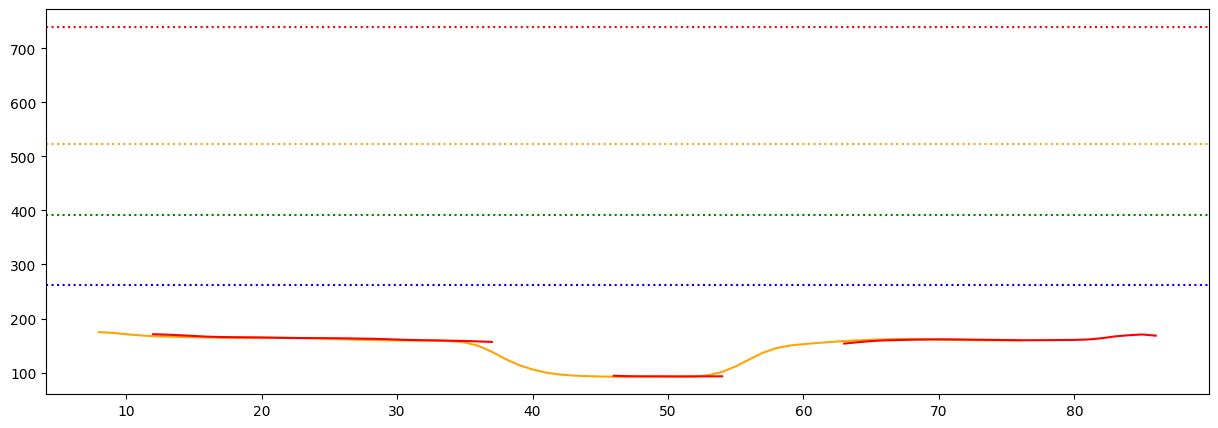

In [5]:
# f0_gen=get_pitch_crepe(*VOCODERS[hparams['vocoder'].split('.')[-1]].wav2spec(wav_gen),hparams,threshold=0.05)
f0_gen,_=get_pitch_parselmouth(*VOCODERS[hparams['vocoder'].split('.')[-1]].wav2spec(wav_gen),hparams)
f0_tst[f0_tst==0]=np.nan#ground truth f0
f0_pred[f0_pred==0]=np.nan#f0 pe predicted
f0_gen[f0_gen==0]=np.nan#f0 generated
fig=plt.figure(figsize=[15,5])
plt.plot(np.arange(0,len(f0_tst)),f0_tst,color='black')
plt.plot(np.arange(0,len(f0_pred)),f0_pred,color='orange')
plt.plot(np.arange(0,len(f0_gen)),f0_gen,color='red')
plt.axhline(librosa.note_to_hz('C4'),ls=":",c="blue")
plt.axhline(librosa.note_to_hz('G4'),ls=":",c="green")
plt.axhline(librosa.note_to_hz('C5'),ls=":",c="orange")
plt.axhline(librosa.note_to_hz('F#5'),ls=":",c="red")
plt.show()
